In [198]:
#!pip install skyfield
from skyfield.api import EarthSatellite
from skyfield.api import load
#!pip install sgp4
from sgp4.api import Satrec
from sgp4.api import jday
import pandas as pd
import numpy as np

TLEs = open('noaa-06.txt', 'r')
time_ = []
i = 0
# jd, fr = jday(1980, 3, 10, 38, 52, 00) 
position = []
# velocity = []
ts = load.timescale()

# iterate through all TLE timepoints
for line in TLEs:
  i+=1
  # for the first line set equal to t and obtain the Julian date
  if i%2==1:
    s = line
    temp = (line.split(' ')[5])
    if temp != '':
      time = temp
      time_.append(time)
  
  # for the second line obtain the Keplerian information
  else:
    if line != '':
      t = line
      # satellite = Satrec.twoline2rv(s, t)
      # e, r, v = satellite.sgp4(jd, fr)
      satellite = EarthSatellite(s, t, 'NOAA-6', ts)
      month = int(int(time[3:5])/31)+1
      day = int(time[3:5])
      frac = int(time[6:12])
      hour_pre = frac*24
      hour = int(hour_pre)
      minute_pre = np.abs(hour-hour_pre)*60
      minute = int(minute_pre)
      seconds_pre = np.abs(minute-minute_pre)*60
      seconds = int(seconds_pre)
      sat_time = ts.utc(1980, month, day, hour, minute, seconds)

      # build a satellite with geocentric inertial frame, obtain position vector in km
      geocentric = (satellite.at(sat_time))
      position.append(geocentric.position.km)
      # position.append(r)
      # velocity.append(v)

In [199]:
# custom function for removing nan 

def clean(arr):
  nan_array = np.isnan(arr)
  not_nan_array = ~ nan_array
  arr_clean = arr[not_nan_array]
  return arr_clean

In [200]:
# clip, clean and reshape data for relevant TLE epochs

time_ = np.array(time_[:13])

position = np.array(position[:15])
position = clean(position)
length = int(len(position)/3)
position = np.reshape(position,(length,3))

# TEME position
# position = np.array(position[:13]) #m
# velocity = np.array(velocity[:13]) #m/s

# cross_track = np.zeros_like(position)
# along_track = np.zeros_like(position)
# radial = np.zeros_like(position)

# for i in range(len(time)):
#   h = np.cross(position[i,:],velocity[i,:])
#   cross_track[i,:] = h/np.linalg.norm(h)
#   t = np.cross(cross_track[i,:], position[i,:])
#   along_track[i,:] = t/np.linalg.norm(t)
#   radial[i,:] = position[i,:]/np.linalg.norm(position[i,:])

In [201]:
from numpy import genfromtxt
my_data = genfromtxt('NOAA_6.csv', delimiter=',')

# obtain position and velocity vectors from STK propogation file
# clean for NaN values with clean function 

time_propogate = my_data[:53103,0]
time_propogate = clean(time_propogate)

position_propogate = my_data[:53103,1:4]
position_propogate = clean(position_propogate)

length = int(len(position_propogate)/3)
position_propogate = np.reshape(position_propogate,(length,3))

velocity_propogate = my_data[:53103,4:8]
velocity_propogate = clean(velocity_propogate)
velocity_propogate = np.reshape(velocity_propogate,(length,3))

In [202]:
time_scaled = np.zeros_like(time_)
time_ = time_.astype(np.str)

# parse the time difference relative to TLE start date
for i in range(len(time_)):
  time_scaled[i] = float(time_[i][3:])-float(time_[0][3:])

# scale into minutes
time_scaled = time_scaled.astype(np.float)*24*60

# min = 0
# abs_min = np.Inf
# #tol = 1e-7
idx = np.zeros(len(time_))

# for step in range(1,len(time_scaled)):
#   print(time_scaled[step])
#   for j in range(1,len(time_propogate)):
#     min = np.abs(time_scaled[step] - time_propogate[j])
#     if min<abs_min:
#       abs_min = min
#       idx[step] = j

# vectorized way of finding corresponding STK time step to the TLE file 
for step in range(1,len(time_scaled)):
  array = np.abs(np.ones_like(time_propogate)*time_scaled[step]-time_propogate)
  idx[step] = np.argmin(array)

# indices of closest fit points
print(idx)

[  0. 162. 221. 261. 298. 318. 381. 486. 561. 820. 830. 861. 885.]


In [243]:
# calculate cross track, along track and radial vectors

idx = idx.astype(int)
position_propogate_clip = position_propogate[idx]
velocity_propogate_clip = velocity_propogate[idx]

# cross_track_prop = np.zeros_like(position_propogate_clip)
# along_track_prop = np.zeros_like(position_propogate_clip)
# radial_prop = np.zeros_like(position_propogate_clip)

values = np.zeros((3,3,len(position_propogate_clip)))
for i in range(len(position_propogate_clip)):
  h = np.cross(position_propogate_clip[i,:],velocity_propogate_clip[i,:])
  cross_track_prop = h/np.linalg.norm(h)
  t = np.cross(cross_track_prop, position_propogate_clip[i,:])
  along_track_prop = t/np.linalg.norm(t)
  radial_prop = position_propogate_clip[i,:]/np.linalg.norm(position_propogate_clip[i,:])
  values[:,:,i] = [radial_prop, along_track_prop, cross_track_prop]

In [244]:
# make change of basis transformation into same frame
# assumption that frame shift minimal over time
start_pos = position[0]
start_pos_rot = position_propogate_clip[0]

transform = np.array([[start_pos[0]/start_pos_rot[0], 0, 0], [0, start_pos[1]/start_pos_rot[1], 0], [0, 0, start_pos[2]/start_pos_rot[2]]])

position_prop_rot = np.zeros_like(position_propogate_clip)
for i in range(len(position_propogate_clip)):
  position_prop_rot[i] = transform@position_propogate_clip[i].T

In [259]:
d_pos = (position_prop_rot - position)/10**9
d_pos_ACR = np.zeros_like(d_pos)

for time in range(len(d_pos)):
  d_pos_ACR[time] = values[:,:,time]@d_pos[time].T

sigma_radial = np.std(d_pos_ACR[:,0]) 
sigma_along = np.std(d_pos_ACR[:,1]) 
sigma_cross = np.std(d_pos_ACR[:,2]) 
print(sigma_radial, sigma_along, sigma_cross)

708.7524829673059 511.16528921925084 216.16229218877749


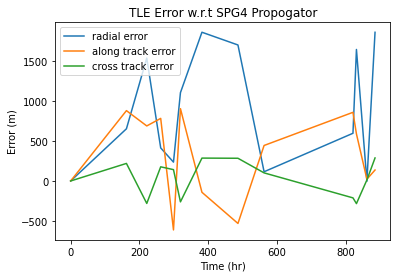

In [255]:
import matplotlib.pyplot as plt

plt.plot(time_scaled/60, d_pos_ACR)
labels = ('radial error','along track error','cross track error')
plt.legend(labels)
plt.title("TLE Error w.r.t SPG4 Propogator")
plt.xlabel("Time (hr)")
plt.ylabel("Error (m)")
plt.show()